In [123]:
import geopandas,arcpy,pandas,numpy

In [99]:
import matplotlib.pyplot as plt

In [1]:
import WeightsUtilities

In [2]:
help(WeightsUtilities)

Help on module WeightsUtilities:

NAME
    WeightsUtilities

DESCRIPTION
    Source Name:   WeightsUtilities.py
    Version:       ArcGIS 10.1
    Author:        Environmental Systems Research Institute Inc.
    Description:   Utilities for creating, managing and utilizing 
                   spatial weights matrix files.

CLASSES
    builtins.object
        DistanceFeatures
        FixedSWMReader
        FixedSWMWriter
        NeighborInfo
        SWMReader
        SWMWriter
        SciPyNeighborSearch
        VariableSWMReader
        VariableSWMWriter
    
    class DistanceFeatures(builtins.object)
     |  DistanceFeatures(ssdo)
     |  
     |  Class to create/store distance features.
     |  
     |  INPUTS:
     |  ssdo (obj): instance of SSDataObject
     |  
     |  ATTRIBUTES:
     |  coords (array): origin coordinates
     |  originIsPoint (bool): whether origins are points
     |  paths (list): list of paths to distance features
     |  names (list): validated distance feat

### 读取swm文件

In [34]:
swm = WeightsUtilities.SWMReader("./cn_queen.swm")

In [35]:
print(swm.description())


                                   Spatial Weights Matrix Description                                  
ArcGIS Version:                      10.1                                                               
Input Feature Class:                 D:\workspace\DevWork\github\PythoneDem_gitee\034SWM文件读取\data\中国.shp
Unique ID Field:                     UID                                                                
Output Spatial Weights Matrix File:  ./cn_queen.swm                                                     
Spatial Reference Name:              China_Lambert_Conformal_Conic                                      
Number of Observations:              35                                                                 
Row Standardization:                 True                                                               
Conceptualization:                   CONTIGUITY_EDGES_CORNERS                                           
Fixed Weight Values:                 True              

In [43]:
swm.numObs

35

In [38]:
OID,Ncnt,Nid = [],[],[]

In [128]:
swm = WeightsUtilities.SWMReader("./cn_queen_hainan.swm")
for i in range(swm.numObs):
    e = swm.swm.readEntry()
    OID.append(e[0])
    Ncnt.append(e[1])
    Nid.append(e[2])

In [129]:
df = pandas.DataFrame({"OID":OID,"邻近对象数量":Ncnt,"邻接对象ID":Nid})

In [130]:
df

OID  邻近对象数量                                             邻接对象ID
0   530000       4                   [450000, 510000, 520000, 540000]
1   510000       7  [500000, 520000, 530000, 540000, 610000, 62000...
2   520000       5           [430000, 450000, 500000, 510000, 530000]
3   500000       5           [420000, 430000, 510000, 520000, 610000]
4   450000       4                   [430000, 440000, 520000, 530000]
..     ...     ...                                                ...
65  320000       4                   [310000, 330000, 340000, 370000]
66  210000       3                           [130000, 150000, 220000]
67  310000       2                                   [320000, 330000]
68  230000       2                                   [150000, 220000]
69  220000       3                           [150000, 210000, 230000]

[70 rows x 3 columns]

In [131]:
pd = pandas.DataFrame(arcpy.da.FeatureClassToNumPyArray("data/中国.shp",["UID","SHAPE@x","SHAPE@y"]))

In [132]:
pnt = pd.set_index("UID").to_dict("index")

In [133]:
from shapely.geometry import LineString

In [134]:
id,line = [],[]
i = 0
for d in df.to_dict("records"):
    s = pnt[d["OID"]]
    try:
        for d2 in d["邻接对象ID"]:
            id.append(i)
            i+=1
            e = pnt[d2]
            l = LineString([(s["SHAPE@x"],s["SHAPE@y"]),(e["SHAPE@x"],e["SHAPE@y"])])
            line.append(l)
    except Exception as e:
        pass
    

In [135]:
linepd = geopandas.GeoDataFrame({"id":id,"geometry":line})

In [136]:
cn = geopandas.read_file("data/中国.shp")

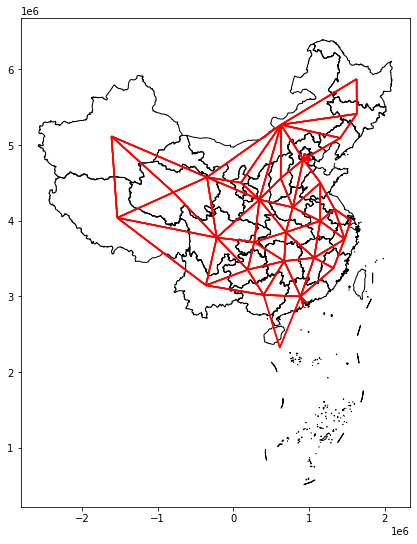

In [137]:
fig,ax = plt.subplots(figsize=(7,9))
linepd.plot(ax= ax,color="red")
cn.plot(ax=ax,color="None")
fig.savefig("连通.jpg")

## 自定义写入

In [121]:
w = {}
swm = WeightsUtilities.SWMReader("cn_queen.swm")
for i in range(swm.numObs):
    info = swm.swm.readEntry()
    w[info[0]] = [info[2],info[3]]

## 海南加入广东广西，同样把广东广西分别加入海南
### 460000: 440000,450000 
### 440000: 追加460000 
### 450000: 追加460000

In [124]:
w[460000] = [numpy.array([440000,450000]),numpy.array([0.5,0.5])]

num = len(w[440000][0])+1
w[440000][0] = numpy.append(w[440000][0],numpy.array(460000))
w[440000][0].sort()
w[440000][1] = numpy.array([float(1/num) for i in range(num)])

num = len(w[450000][0])+1
w[450000][0] = numpy.append(w[450000][0],numpy.array(460000))
w[450000][0].sort()
w[450000][1] = numpy.array([float(1/num) for i in range(num)])

## 定义各种元数据参数

In [126]:
uniqueID = swm.masterField
spatialRefName = swm.spatialRefName
n = swm.numObs
rowStandard = swm.rowStandard

In [127]:
swmw = WeightsUtilities.SWMWriter("cn_queen_hainan.swm",uniqueID,spatialRefName,n,rowStandard)
for w1 in w:
    try:
        if w[w1][0] is None:
            swmw.swm.writeEntry(w1,[], [])
        else:
            swmw.swm.writeEntry(w1,w[w1][0], w[w1][1])
    except:
        print("------ ",w)
swmw.close()